In [163]:
import numpy as np
import pandas as pd


from scipy.fft import fft
from scipy.interpolate import griddata


import matplotlib as mpl
import matplotlib.pyplot as plt

# Set matplotlib color cycle
viridis_colors = plt.cm.viridis(np.linspace(0.1,0.9,6))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=viridis_colors)

# Set matplotlib color map
mpl.rc('image', cmap='viridis')

In [77]:
data = pd.read_json('./logins.json')
data.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


OK, looks like we have about 93k records, not all of them unique (multiple people logging in at the same time). The data spans about three and a quarter months starting in January of 1970. Let's go ahead and sum the data in 15 minute intervals using panda's resample.

In [78]:
# resample data on login time, using the number of logins per 15 min. bin
resampled_data = data.resample('15T', on='login_time').count()

# rename count column (note: login time is now index)
resampled_data.rename(columns={'login_time': 'login_count'}, inplace=True)
resampled_data.reset_index(inplace=True)
resampled_data.head()

,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


Before we do anything else to the data, let's take a look at the whole range as a sanity check.

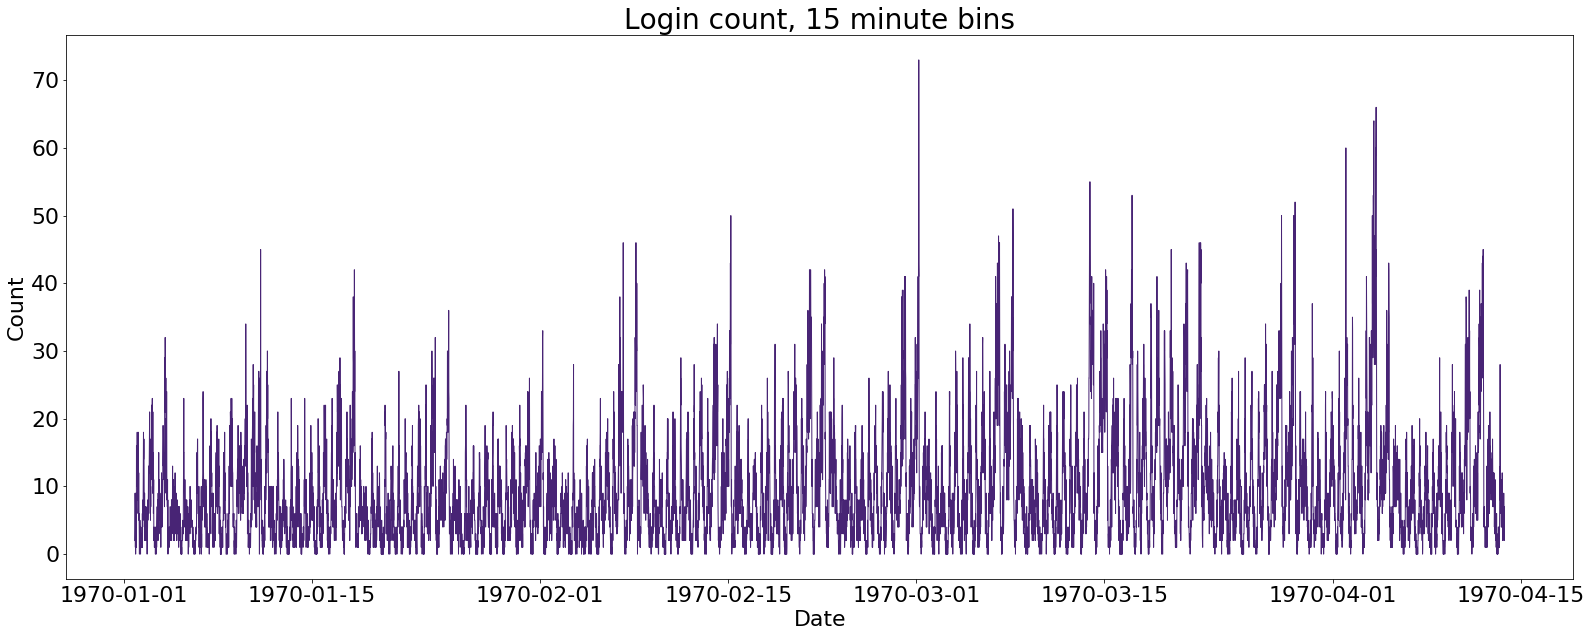

In [79]:
fig, ax = plt.subplots(figsize=(27, 10))
ax.plot(resampled_data['login_time'], resampled_data['login_count'], linewidth=1)
ax.tick_params(labelsize=22)
ax.set_title('Login count, 15 minute bins', fontsize=28)
ax.set_xlabel('Date', fontsize=22)
ax.set_ylabel('Count', fontsize=22)
plt.show()

Looks good. Seems to have full coverage over the date range. No obvious chunks of missing data. No extreme values. Appears to be a slight upward trend over time. Also, we clearly have a good amount of periodicity. Let's look at that next.

In [94]:
# Number of sample points
N = 600

# sample spacing
T = 1.0 / 800.0

# time domain x and y
x = resampled_data.index
y = resampled_data['login_count']

# transform to frequency domain
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# convert xf frequency in hours
xf = xf / 60

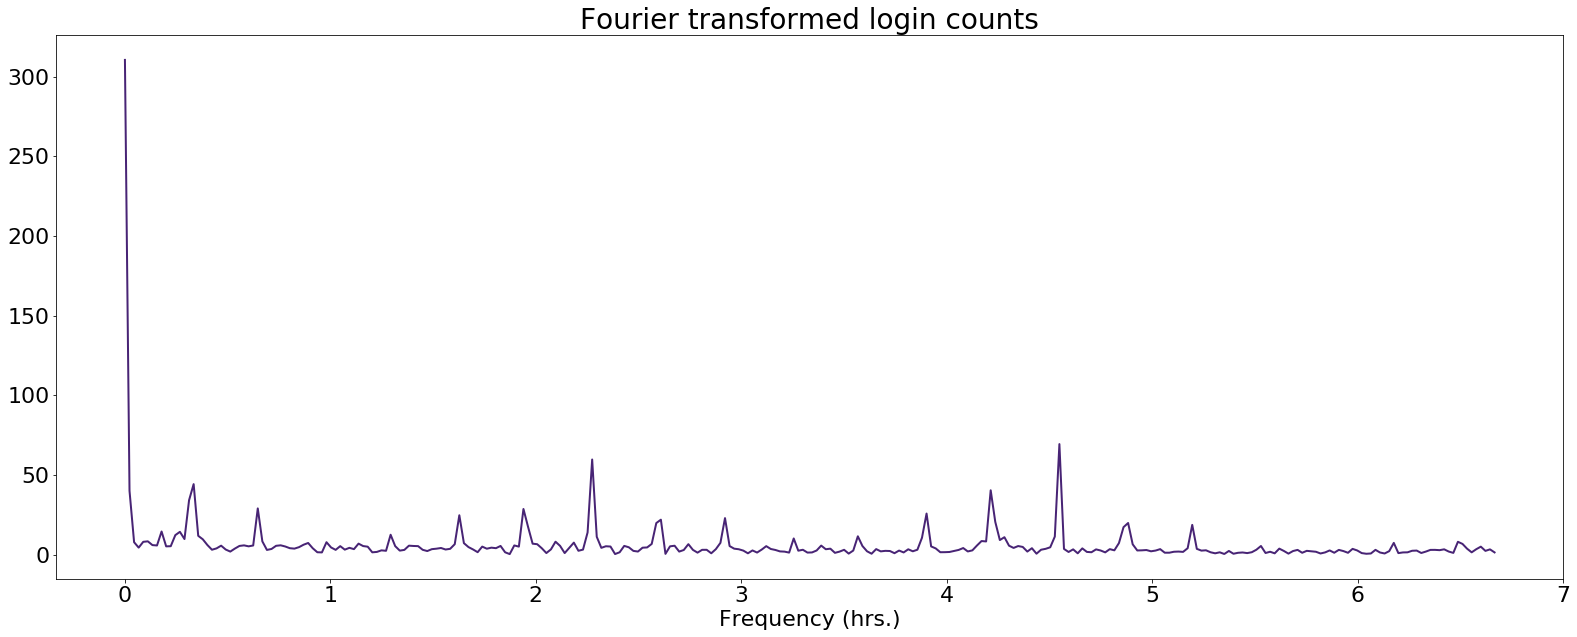

In [146]:
# plot result
fig, ax = plt.subplots(figsize=(27, 10))
ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]), linewidth=2)
ax.tick_params(labelsize=22)
ax.set_title('Fourier transformed login counts', fontsize=28)
ax.set_xlabel('Frequency (hrs.)', fontsize=22)
plt.show()

Interesting, frequency spectrum is mostly quantized on a 15 minute interval. This makes sense, give that we aggregate using a 15 minute bin width. The two strongest peaks appear to be at 2.25 and again at 4.5, exactly double. Think I have some ideas about what is going on here, but let's look at trends over day, week and month. 

In [144]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
week_data = resampled_data.groupby(resampled_data['login_time'].dt.day_name()).sum().reindex(days)

day_data = resampled_data.groupby(resampled_data['login_time'].dt.hour).sum()
day_data.index = pd.to_datetime(day_data.index, unit='h').strftime("%I:%M %p")

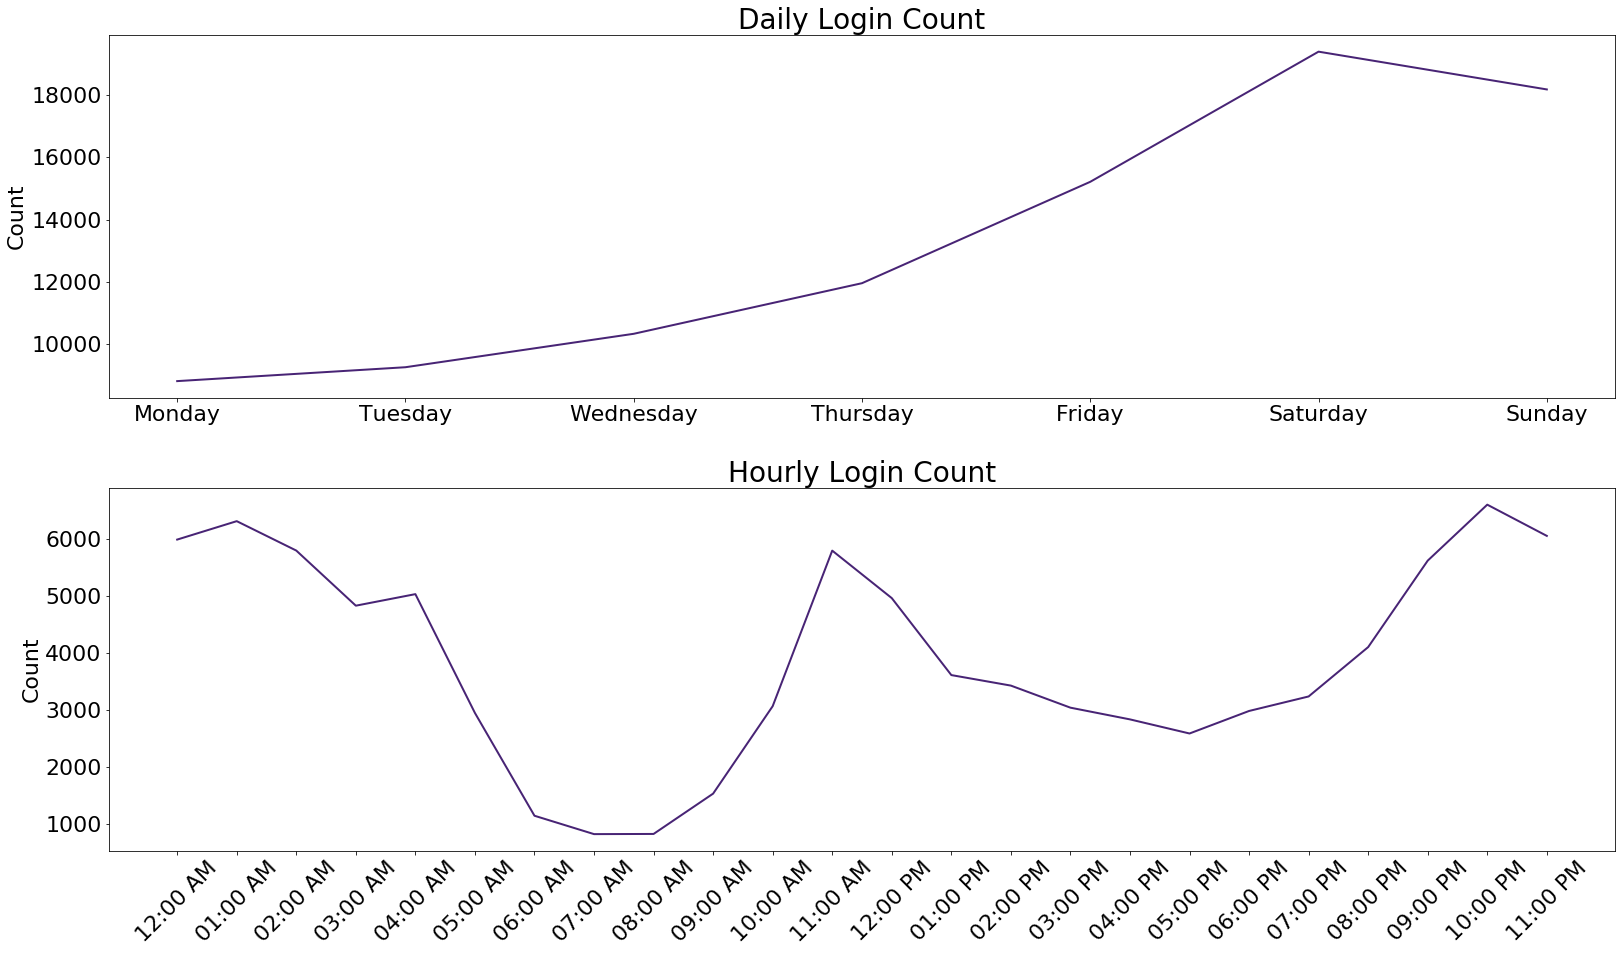

In [148]:
fig, ax = plt.subplots(2, 1, figsize=(27, 15))

fig.subplots_adjust( 
    hspace=0.25
)

plt.xticks(rotation=45)

ax[0].plot(week_data.index, week_data['login_count'], linewidth=2)
ax[0].tick_params(labelsize=22)
ax[0].set_title('Daily Login Count', fontsize=28)
ax[0].set_ylabel('Count', fontsize=22)

ax[1].plot(day_data.index, day_data['login_count'], linewidth=2)
ax[1].tick_params(labelsize=22)
ax[1].set_title('Hourly Login Count', fontsize=28)
ax[1].set_ylabel('Count', fontsize=22)

plt.show()

In [159]:
resampled_data['day'] = resampled_data['login_time'].dt.dayofweek
resampled_data['hour'] = resampled_data['login_time'].dt.hour
hour_by_day_data = resampled_data.groupby(['day', 'hour']).sum()
hour_by_day_data.reset_index(inplace=True)

In [160]:
resampled_data.head()

,login_time,login_count,day,hour
0,1970-01-01 20:00:00,2,3,20
1,1970-01-01 20:15:00,6,3,20
2,1970-01-01 20:30:00,9,3,20
3,1970-01-01 20:45:00,7,3,20
4,1970-01-01 21:00:00,1,3,21


In [161]:

hour_by_day_data.head()

,day,hour,login_count
0,0,0,531
1,0,1,414
2,0,2,312
3,0,3,236
4,0,4,206


In [215]:
x = hour_by_day_data['day']
y = hour_by_day_data['hour']
z = hour_by_day_data['login_count']

# target grid to interpolate to
xi = np.arange(hour_by_day_data['day'].min(), hour_by_day_data['day'].max(), 0.1)
yi = np.arange(hour_by_day_data['hour'].min(), hour_by_day_data['hour'].max(), 0.1)
xi2, yi2 = np.meshgrid(xi, yi)

# interpolate
zi = griddata((x, y), z, (xi2, yi2), method='linear')

#yi = pd.to_datetime(yi, unit='h').strftime("%I:%M %p")
#yi = pd.to_datetime(yi).day_name()
#yi

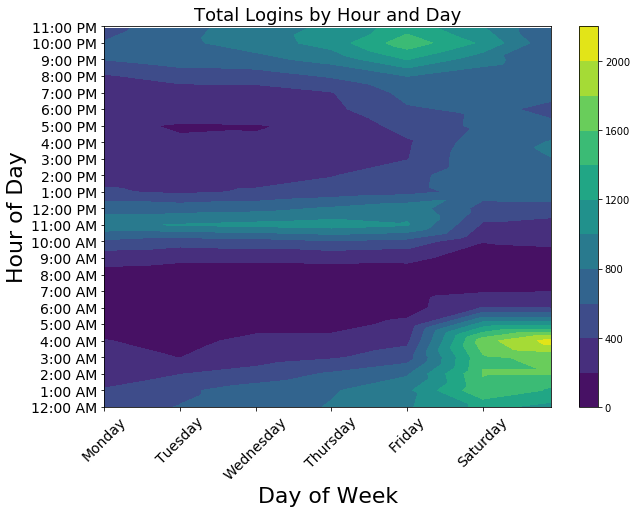

In [234]:
fig, ax = plt.subplots(figsize=(10, 7))
CS = ax.contourf(xi, yi, zi, 10, cmap='viridis')
cbar = fig.colorbar(CS)
ax.set_title('Total Logins by Hour and Day', fontsize=18)
ax.set_xlabel('Day of Week', fontsize=22)
ax.set_ylabel('Hour of Day', fontsize=22)
ax.tick_params(labelsize=14)
plt.xticks(np.arange(7), ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"), rotation=45)
plt.yticks(np.arange(24), ("12:00 AM", "1:00 AM", "2:00 AM", "3:00 AM", "4:00 AM", "5:00 AM", "6:00 AM", "7:00 AM", "8:00 AM", "9:00 AM", "10:00 AM", "11:00 AM", "12:00 PM", "1:00 PM", "2:00 PM", "3:00 PM", "4:00 PM", "5:00 PM", "6:00 PM", "7:00 PM", "8:00 PM", "9:00 PM", "10:00 PM", "11:00 PM"))
ax.margins(x=0)
plt.show()